Hi, this notebook was written by Todd Hendricks. My intent is to share an abbreviated version of my workflow and thought process as I develop a model prototype. The code and codemmentary are all mine.

## Table of Contents:
* [Introduction](#intro)
* [The Business Case For Modeling](#biz)
* [The Data](#data)
* [Workflow](#work)
* [Summary of Findings](#findings)
* [Limitations](#limitations)
* [Next Steps](#next)

### Introduction <a class="anchor" id="intro"></a>

Transportation is the number one source of greenhouse gas emissions in the United States. Transitioning to electric vehicles is a critical part of climate change strategy. Yet while renewable energy sources have blossomed, electrical vehicle adoption has fallen short of where many experts predicted we would be at this stage. This is the macro level view.

The micro level can be described as a lack of infrastructure to support growth; under that term resides a complex and interdependent problem set. This notebook explores one of them: accurately modeling the length of a charging session. Without this ability, EVs will "wreck havoc on the grid" according to [a recent report](https://www.woodmac.com/our-expertise/capabilities/electric-vehicles/2040-forecast/). As was recently [described in Car And Driver magazine](https://www.caranddriver.com/shopping-advice/a32600212/ev-charging-time/):

>Figuring precisely how long it takes to charge an electric car is akin to asking, "how long does it take to cross the country?” It depends whether you’re in a plane or on foot. Recharge time is dependent on a host of variables, many of them nuanced—even the length of the charging cable can influence it—that make providing a precise answer impossible.

Others have tried to apply machine learning to the problem; the [ACN-Data project at Caltech](https://ev.caltech.edu/research) largely inspired my work here. I believe that predicting charging session length has the potential to be a successful application of machine learning. As discussed below, reaching that point would require all stakeholders to share more data.

### The Business Case For Modeling <a class="anchor" id="biz"></a>

Every data science project requires a commercial justification, but this is a case where there is no clear ownership of the problem. Yet there are economic incentives for multiple parties involved. Through improved ability to forecast load, investor-owned utilities would see improved reliability of the distribution network, reducing operations and maintenance costs. Indeed, [researchers estimate](https://www.mdpi.com/1996-1073/13/16/4231) that increased penetration of EV led to a 10x increase in distribution transformer failures. 

Charging networks and the users/members would enjoy the benefit of managed expectations of timing. Much like package tracking has improved the experience of sending and receiving mail, the transparent ETA of a charging session will ease one of the annoyances of owning an EV and improve customer satisfaction. 

But this is a collective action problem. It doesn't make sense for any market actor to step in to build the data infrastructure required to implement predictive modeling.

### The Data <a class="anchor" id="data"></a>

My sample is from the publicly available data provided by [Caltech](http://ev.caltech.edu/), from the charging sessions on campus, one of the largest EV charging locations in the country.

### Workflow <a class="anchor" id="work"></a>

#### Iteration 0: Baseline

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot

In [110]:
json_file_path = "/Users/toddhendricks/Downloads/acndata_sessions.json"
with open(json_file_path, 'r') as j:
     data = json.loads(j.read())     
df = pd.json_normalize(data['_items'])

In [111]:
df.head(5)

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5e225f9ff9af8b5c26d21718,0039,"Thu, 02 Jan 2020 01:12:29 GMT","Thu, 02 Jan 2020 04:38:39 GMT","Thu, 02 Jan 2020 03:11:48 GMT",8.336,2_39_126_20_2020-01-02 01:12:28.778216,0002,CA-310,2-39-126-20,America/Los_Angeles,000001099,"[{'WhPerMile': 400, 'kWhRequested': 24.0, 'mil..."
1,5e225f9ff9af8b5c26d21719,0039,"Thu, 02 Jan 2020 04:18:06 GMT","Fri, 03 Jan 2020 00:06:13 GMT","Thu, 02 Jan 2020 06:41:48 GMT",14.731,2_39_79_382_2020-01-02 04:18:06.407434,0002,CA-491,2-39-79-382,America/Los_Angeles,000003267,"[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mil..."
2,5e23b122f9af8b5fe4b973bf,0039,"Thu, 02 Jan 2020 16:05:15 GMT","Fri, 03 Jan 2020 00:11:51 GMT","Thu, 02 Jan 2020 16:39:20 GMT",2.083,2_39_79_380_2020-01-02 16:05:14.818106,0002,CA-489,2-39-79-380,America/Los_Angeles,000000751,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,5e23b122f9af8b5fe4b973c0,0039,"Thu, 02 Jan 2020 16:06:34 GMT","Thu, 02 Jan 2020 17:04:02 GMT","Thu, 02 Jan 2020 16:37:26 GMT",0.855,2_39_79_383_2020-01-02 16:06:34.210024,0002,CA-492,2-39-79-383,America/Los_Angeles,None,None
4,5e23b122f9af8b5fe4b973c1,0039,"Thu, 02 Jan 2020 16:31:35 GMT","Fri, 03 Jan 2020 00:29:28 GMT","Fri, 03 Jan 2020 00:29:26 GMT",50.788,2_39_78_366_2020-01-02 16:31:34.854057,0002,CA-323,2-39-78-366,America/Los_Angeles,000003853,"[{'WhPerMile': 360, 'kWhRequested': 64.8, 'mil..."


In [112]:
# Generate a summary description of the dataset.
charging_slots = df.stationID.nunique()
customers = df.userID.nunique()
sessions = df.sessionID.nunique()
total_mwh_delivered = sum(df.kWhDelivered) / 1000
avg_kwh_delivered = df.kWhDelivered.mean()
"There are {} charging stations on the Caltech campus. The data contains {} unique customers of the stations, with {} unique charging sessions over the course of 2020. The total energy delivered was {} megawatt hours, with the average session delivering {} kilowatt hours.".format(charging_slots, customers, sessions, total_mwh_delivered, avg_kwh_delivered)

'There are 50 charging stations on the Caltech campus. The data contains 203 unique customers of the stations, with 2352 unique charging sessions over the course of 2020. The total energy delivered was 18.709586259402627 megawatt hours, with the average session delivering 7.954756062671184 kilowatt hours.'

Our target is the duration of a charging session represented in hours. We will need to convert the relevant columns to datetime objects in order to facilitate the time math.

In [113]:
df.connectionTime = pd.to_datetime(df.connectionTime)
df.doneChargingTime = pd.to_datetime(df.doneChargingTime)
df.connectionTime = pd.to_datetime(df.connectionTime.dt.strftime('%m/%d/%Y %H:%M')) 
df.doneChargingTime = pd.to_datetime(df.doneChargingTime.dt.strftime('%m/%d/%Y %H:%M'))

df['charging_session_duration'] = df.connectionTime - df.doneChargingTime
df['charging_session_duration_in_hrs'] = (df['charging_session_duration'] / np.timedelta64(1, 'h')) * -1

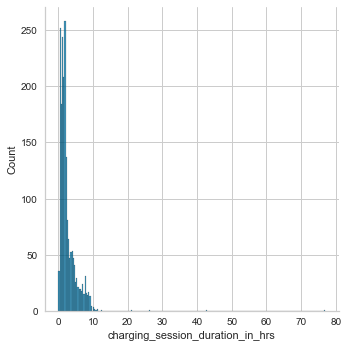

In [114]:
sns.displot(df['charging_session_duration_in_hrs'])

This plot tells us that our target is right skewed; most of the charging sessions are less than ten hours, but there are a very small number of sessions that have gone as long as eighty hours. 

Yet the tail is very thin. Based on this plot, I am considering a session running longer than ten hours to be an outlier and omit them from the dataframe.

In [115]:
df_less_outliers = df[df['charging_session_duration_in_hrs'] <= 10]

In [116]:
n = 2
data_lost = (len(df_less_outliers) / len(df)) * 100
print("After removing outliers, we have {0:.{1}f} percent of the data we began with.".format(data_lost, n))

After removing outliers, we have 83.72 percent of the data we began with.


In [117]:
df_less_outliers.columns 

Index(['_id', 'clusterID', 'connectionTime', 'disconnectTime',
       'doneChargingTime', 'kWhDelivered', 'sessionID', 'siteID', 'spaceID',
       'stationID', 'timezone', 'userID', 'userInputs',
       'charging_session_duration', 'charging_session_duration_in_hrs'],
      dtype='object')

We do not have a large feature space. My first question is about the relationship between kWhDelivered and our target, the session length. Intuitively, I would assume some degree of correlation between how much energy a user received, and how long it would take them to get it. Let's see.

<AxesSubplot:xlabel='kWhDelivered', ylabel='charging_session_duration_in_hrs'>

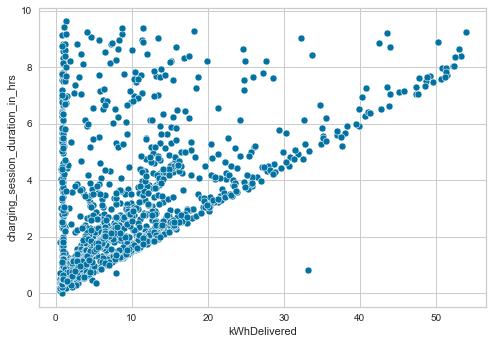

In [118]:
sns.scatterplot(data=df_less_outliers, x='kWhDelivered', y='charging_session_duration_in_hrs')

Two important points here.

First, the scatterplot reveals a fundamental property of the problem: the relationship between how much energy is delivered, and how long it takes to receive that energy is positively correlated - but not strongly enough to provide predictive value. Stated simply, it's not as linear as one would hope/expect. 

When trending the energy delivered on a solar installation, for example, to electricity flowing to the meter is almost perfectly linear with the amount of solar resource available; if you plot energy delivered (on a sunny day), the signature will mirror the rise and fall of the sun. Modeling and measurement uncertainy combined tends to hover around 5-8%.

We don't see that linearity here. Our plot shows that, for a user to have 15 kWh of charge, it could take two and a half hours - but it could just as easily take six. There is a limit to how fast a vehicle can be charged - but there's no upper bound. Physics would explain the lower boundary. We do not yet know what covariate(s) explain the variance above the line.

Secondly, it's worth noting that we would not have access to kWhDelivered in a production environment since it is produced after the session ends. However, I think we could extract that signal from past user behavior, much like a credit score. Let's take a look at the top four users to see how much variance exists among the most frequent customers.

In [119]:
forty_three = df[df['userID'] == '000000743']
seventy = df[df['userID'] == '000001470']
sixty_six = df[df['userID'] == '000001366']
oh_one = df[df['userID'] == '000004701']
top_users = pd.concat([forty_three,seventy,sixty_six,oh_one])

<AxesSubplot:xlabel='kWhDelivered', ylabel='Density'>

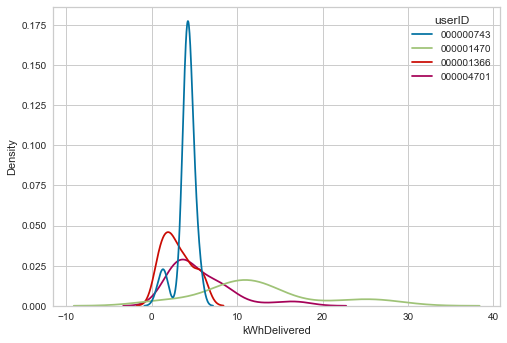

In [120]:
sns.kdeplot(data=top_users, x="kWhDelivered", hue="userID")

<AxesSubplot:xlabel='kWhDelivered', ylabel='charging_session_duration_in_hrs'>

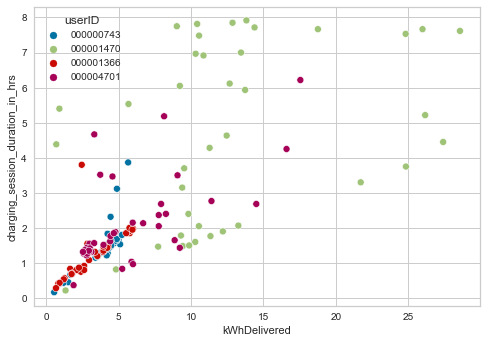

In [121]:
sns.scatterplot(data=top_users, x='kWhDelivered', y='charging_session_duration_in_hrs', hue='userID')

The kernel density estimate shows that user 0743 tends to be much more predictable than his/her colleagues. On the other end of the spectrum, user 1470 tends to do have a different experience every time. Perhaps the most interesting feature of the cohort is how tightly grouped they are until two hours of charge - and then all bets are off.

In terms of features, we will move forward with an aggregate value of historical kWh Delivered per session. Because there tends to be a rightward skew - most evident in 4701 and 1366 - we will use the median for the user, which is a better measure of central tendency in this case, and provides more predictive value. 

In [122]:
median_energy_delivered = df_less_outliers.groupby(['userID'])['kWhDelivered'].median()
median_energy_delivered_dict = dict(median_energy_delivered)

In [137]:
df_less_outliers['median_energy_delivered'] = df_less_outliers.loc[:,'userID'].map(median_energy_delivered_dict)

At this stage, there is still a lot to learn about the problem, generally, and about the feature space, specifically. When prototyping, I believe it is best practice to start simple and optimize for interpretability. For these reasons, I start with ordinary least squares regression. 

In [124]:
df_less_outliers = df_less_outliers.dropna()
X,y = df_less_outliers['median_energy_delivered'], df_less_outliers['charging_session_duration_in_hrs']
X = X.values.reshape(-1,1)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [126]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [127]:
lr.score(X_test, y_test)

0.32746427262525457

We now have a baseline. Let's evaluate the model. 

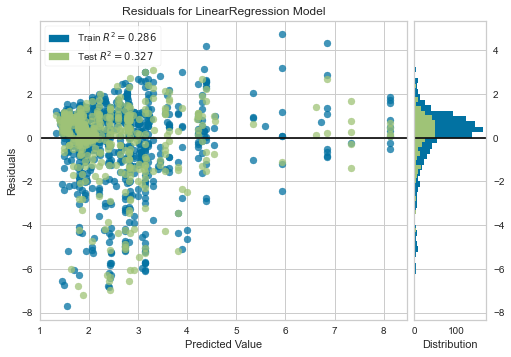

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [128]:
res_plot = ResidualsPlot(lr)
res_plot.fit(X_train, y_train)  
res_plot.score(X_test, y_test)
res_plot.show()

The distribution of our residuals reveals our challenge. Ideally, the residual plot would be normally distributed, with errors reasonably balanced on both sides. But the current distribution is skewed to the right, mirroring our target distribution. 

Our baseline model has high bias. An improved model will need to strike a better balance between bias and variance.

#### Iteration 1: Session Length

We build on the idea of the first feature for our second: past behavior as the best predictor. The distribution of the median sesssion length is skewed much like the distribution of energy delivered - although they are mostly independent.

In [129]:
median_session_by_user = df_less_outliers.groupby(['userID'])['charging_session_duration_in_hrs'].median()
median_session_by_user_dict = dict(median_session_by_user)
df_less_outliers['median_session_by_user'] = df_less_outliers['userID'].map(median_session_by_user_dict)

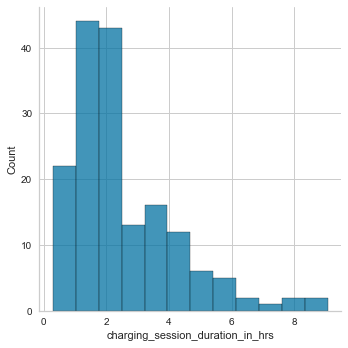

In [130]:
sns.displot(median_session_by_user)

In [131]:
df_less_outliers = df_less_outliers.dropna()
X = df_less_outliers[['median_session_by_user','median_energy_delivered']]
y = df_less_outliers['charging_session_duration_in_hrs']
X = X.values

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [133]:
median_session_lr = LinearRegression()

In [134]:
median_session_lr.fit(X_train, y_train)

LinearRegression()

In [135]:
median_session_lr.score(X_test, y_test)

0.49647925395279846

Given that we have implemented a measure of central tendency based on historical behavior as a feature for our model - and it explains less than half of the variance - it supports the conclusion that we only have a fraction of explanatory value available to us at this time.

The learning curve below clearly demonstrates the need for more data. Toward the end of our training instances on the X axis, we see no meaningful reduction in the variance of the model. With a good model, we would expect the shaded area to decrease as the training instances increase. 

/Users/toddhendricks/miniconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


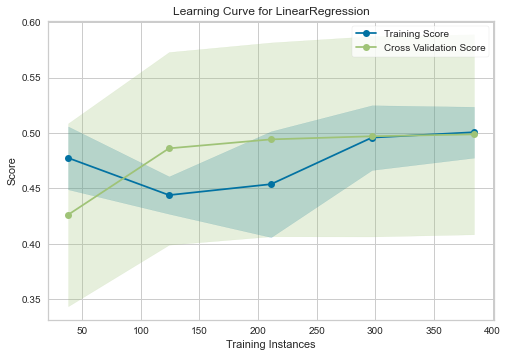

<AxesSubplot:title={'center':'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [136]:
learn_curve = LearningCurve(median_session_lr, scoring='r2')
learn_curve.fit(X_test,y_test)
learn_curve.show()

### Summary of Findings <a class="anchor" id="findings"></a>

Our model prototype predicts the duration of a charging session with reasonable accuracy - up until the two hour mark. After two hours, the linear nature between energy received, and the time it takes to receive it, breaks down. With user data alone, we cannot meaningfully predict the duration of a charging session once it passes the approximate two hour mark. 

Another interesting fact: to initiate a charging session, a user provides parameters regarding how much energy they would like and general properties of his or her vehicle. Perhaps the most surprising finding was how poorly correlated that data was with the outcome of the charging session. 

### Limitations <a class="anchor" id="limitations"></a>

The features of the model are behavioral. We learned about the users of the EV charging system, but not about the system itself. There is no objective truth, so to speak. A durable model would find a way to decouple user behavior from predictions. 

No doubt, there are important features independent of user behavior that influence the charging time. Further, we do not know whether the customer behavior at Caltech will generalize to other charging stations and/or subsets of customers. It would be good to have features that are sturdier and more deterministic. Hardware specifications of the relevant components - onboard charger rating, battery capacity, etc. - are obviously a better predictor.

This approach would not likely scale well. Given the user-centric nature, this would require making the historical data (if there is any) available in serving, and would potentially result in hundreds of models in production. I suspect it would be technically infeasible for most organizations.

### Next Steps <a class="anchor" id="next"></a>

We need more data. All demand side stakeholders will need to provide more metadata in order to help utilities properly forecast load. Critical components like onboard charger rating, for example, help constrain the model. The electrical engineering variables in this context have been [examined elsewhere](https://doi.org/10.3390/wevj9020017). From a data engineering standpoint, this metadata needs to be managed and endpoints need to be exposed. A starting point would include, but not be limited to:

* Onboard charger rating
* Battery capacity
* Battery state-of-charge

I'm sure there are a plethora of commercial/legal/privacy reasons for why the data is not publicly available. But if we want to accelerate our adoption of electric vehicles and honor our commitments to reduce global warming, we will need to find a way to solve this problem.

Thanks for taking the time to review my work! Any feedback, questions, comments, or feedback is most welcome. You can reach me on [Linkedin](https://www.linkedin.com/in/todd-hendricks/), or via email: hendricks.ta@gmail.com